In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
import numpy as np

In [96]:
transform = transforms.Compose([transforms.Resize((100, 100)),
                                    transforms.ToTensor(),
                                   ])
train_images = datasets.ImageFolder('insects/train', transform = transform)
train_loader = torch.utils.data.DataLoader(train_images, batch_size = 32, shuffle = True)
test_images = datasets.ImageFolder('insects/test', transform = transform)
test_loader = torch.utils.data.DataLoader(test_images, batch_size = 32, shuffle = True)

In [80]:
#check image size
train_images[0][0].size()

torch.Size([3, 84, 84])

In [100]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride = 2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),    
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=64*12*12, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features = 100, out_features = 3)
        )


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        
        return x

In [82]:
model = LeNet()

In [83]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([32, 3, 84, 84])
torch.Size([32])


In [84]:
print(model)

LeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)


In [85]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [94]:
def get_accuracy(model, data_loader, device):
    '''function for computing accuracy'''
    
    correct = 0
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X.to(device)
            y_true = y_true.to(device)
            
            y_hat = model(X)
            predictions = torch.argmax(y_hat, dim=1)
            correct += (predictions == y_true).sum()
            n+= y_true.size(0)
    return correct.float()/n

In [87]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
        
        # Forward pass
        y_hat =model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()
        
        
        
    epoch_loss = running_loss/len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [88]:
def test(test_loader, model, criterion, device):
    model.eval()
    running_loss = 0
    
    for X, y_true in test_loader:
        
        X = X.to(device)
        y_true = y_true.to(device)
        
        y_hat = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item()
    epoch_loss = running_loss/len(test_loader.dataset)
    
    return model, epoch_loss

In [89]:
def training_loop(model, criterion, optimizer, train_loader,test_loader,epochs,device, print_every = 1):
    best_loss = 1e10
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        
        #training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        #test
        with torch.no_grad():
            model, test_loss = test(test_loader, model, criterion, device)
            test_losses.append(test_loss)
        
        if epoch%print_every == (print_every -1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            test_acc = get_accuracy(model, test_loader, device = device)
            
            print(f'Epoch: {epoch}\t'
                  f'train loss: {train_loss: .5f}\t'
                  f'test loss : {test_loss: .5f}\t'
                  f'train accuracy: {100*train_acc:.3f}\t'
                  f'test accuracy: {100*test_acc:.3f}')
            
    return model, optimizer, (train_losses, test_losses)
                 

In [101]:
model = LeNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 15
criterion = nn.CrossEntropyLoss()
model, optimizer, losses = training_loop(model, criterion, optimizer, train_loader, test_loader, epochs, DEVICE)

Epoch: 0	train loss:  0.02561	test loss :  0.02357	train accuracy: 78.606	test accuracy: 73.333
Epoch: 1	train loss:  0.01584	test loss :  0.01784	train accuracy: 85.574	test accuracy: 82.222
Epoch: 2	train loss:  0.01275	test loss :  0.01670	train accuracy: 88.616	test accuracy: 83.889
Epoch: 3	train loss:  0.01255	test loss :  0.02040	train accuracy: 82.336	test accuracy: 72.222
Epoch: 4	train loss:  0.01054	test loss :  0.01247	train accuracy: 90.579	test accuracy: 84.444
Epoch: 5	train loss:  0.00866	test loss :  0.01471	train accuracy: 88.224	test accuracy: 81.111
Epoch: 6	train loss:  0.00769	test loss :  0.00954	train accuracy: 92.836	test accuracy: 89.444
Epoch: 7	train loss:  0.00642	test loss :  0.00982	train accuracy: 92.836	test accuracy: 87.222
Epoch: 8	train loss:  0.00580	test loss :  0.00676	train accuracy: 93.916	test accuracy: 91.667
Epoch: 9	train loss:  0.00441	test loss :  0.00554	train accuracy: 94.701	test accuracy: 93.889
Epoch: 10	train loss:  0.00334	test loss

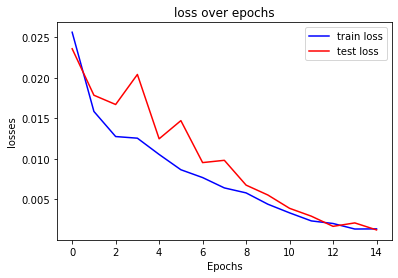

In [143]:
train_losses = np.array(losses[0])
test_losses = np.array(losses[1])
plt.plot(train_losses, color = 'b', label = 'train loss')
plt.plot(test_losses, color = 'r', label = 'test loss')
plt.title('loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('losses')
plt.legend();